This notebook is the step 1 of 3'READS+ pipeline. It will search, download, merge, and QC fastq files, trim 3' adapter, **trim 5' Ts while recording information about the trimmed sequences**, map the trimmed reads to the genome, **identify PASS reads and unique PASS reads** using recorded information from the 5'T trimming step, **cluster neighboring PASS reads** in the genome to define poly(A) sites, and **create genome browser tracks for both PASS and nonPASS reads**. Most of the computation intensive steps are done by parallel computing.

**Required softwares**
 * PASS.py and FastqQC.R in the modules folder 
 * cutadapt, STAR, samtools, genomeCoverageBed, bedGraphToBigWig in your system's PATH
 * Python packages: rpy2, time, warnings, sys, os, re, pathlib, suprocess, collections, itertools, numpy, pandas, seaborn, multiprocessing, webbrowser
 * R packages: foreach, doParallel, ShortRead, Biostrings, dplyr, tidyr, grid, ggplot2
 * Linux environment
 
**Hardware requirements**
 * At least 48G RAM for fast mapping of the reads using STAR. 
 * Muticore CPU for parallel computing

## Load packages an settings for this notebook
Please note that more required packages are loaded when importing PASS.py, a custom module for processing 3'READS+ data.

In [2]:
%load_ext rpy2.ipython 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import rpy2.robjects.numpy2ri as n2r
from time import sleep
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('/home/dinghai/dev/3-prime-READS-plus/modules')
from PASS import *

## Set parameters specific to this project and experiment
These parameters need to be specified for different projects and experiments. The format of SAMPLE_DESCRIPTION_FILE will be shown later. 

In [2]:
PROJECT = 'ER' # Project name

EXPERIMENT = '160411_C2C12_Dif' # Experiment name

GENOME = 'mm9' # Genome name, either mm9 or hg19

SEQUENCER = 'nextseq' # Either "hiseq" or "nextseq"

SAMPLE_DESCRIPTION_FILE = 'sample_description.csv' # Sample discription file.
    
FASTQ_QC_PLOT_NUM_COLUMNS = 4  # Number of columns for fastq QC plots

SAVE_SPACE = True # To save space, delete intermediate files asap.    

SPIKE_IN = None # None if no spike-in, or a 4-charactor string for identifying spike-in RNA. 
# SPIKE_IN = 'ychr' # yeast RNA spike-in if yeast chromosomes are named as 'ychr*' in the genome index files

DATA_SOURCE = 'internal_warehouse' # Either 'internal_warehouse' or 'local'

## Set general parameters
The following parameters are usually set once before running the notebook the first time and can be reused for different experiments. 

In [3]:
# Configurations for data source
if DATA_SOURCE == 'internal_warehouse':
    WAREHOUSE_USER = 'zhengdh'
    WAREHOUSE_SERVER = 'intron.njms.rutgers.edu'
elif DATA_SOURCE == 'basespace':
    BASESPACE_PROJECT = ''
    BASESPACE_TOKEN = ''
elif DATA_SOURCE == 'local':
    LOCAL_DATA_SOURCE = '/home/dinghai/dev/3-prime-READS-plus/tests/data'
    assert Path(LOCAL_DATA_SOURCE).exists()


# Configurations for read alignment    
# Directory containing index files for different genomes
GENOME_INDEX_DIR = '/home/dinghai/projects/fud/star_index'
# Specific genome index for STAR
genome_index = Path(GENOME_INDEX_DIR)/GENOME
# Directory containing fasta files for different genomes
GENOME_FASTA_DIR = '/home/dinghai/projects/fud/ucsc/genomes' 
# Specific genome sequence in fasta format for identifying PASS reads
genome_dir = Path(GENOME_FASTA_DIR)/GENOME
assert genome_index.exists(), f"Please make sure the following genome index folder exists: {str(genome_index)}"
assert genome_dir.exists(), f"Please make sure the following genome fasta file folder exists: {str(genome_dir)}"


# Configurations for using UCSC genome browser to visualize PASS and nonPASS reads   
MAKE_URL = True # Set to True if you have access to an http server.        
if MAKE_URL:
    HTTP_USER = 'zhengdh'
    HTTP_SERVER = 'intron.njms.rutgers.edu'

    
# Other configurations
# Maximum number of processes for parallel computing
MAX_WORKERS = 8  
# Minimum read lenth after removing 5' adapter
CUTADAPT_MINLEN = 25  
# Minimum MAPQ score for alignments in sam files
MIN_MAPQ = 10  
# Sequencing direction relative to mRNA sequence. Either 'reverse' (antisense) or 'forward' (sense).
SEQ_DIRECTION = 'reverse' 
# Maximum distance between clustered reads in the same cluster
MAX_DISTANCE = 24 
genome_size = f'~/projects/fud/ucsc/genomes/{GENOME}.chrom.sizes'

The following lines set up directories for saving data and intermediate results.

In [4]:
# Project directory
project_dir = Path(f'projects/{PROJECT}')
# Data directories
data_dir = project_dir/'data'/EXPERIMENT
rawfastq_dir = data_dir/'rawfastq'
fastq_dir = data_dir/'fastq'
sam_dir = data_dir/'sam'
# Result directory
result_dir = project_dir/'result'/EXPERIMENT

# Create directories
project_dir.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)
rawfastq_dir.mkdir(parents=True, exist_ok=True)
fastq_dir.mkdir(parents=True, exist_ok=True)
sam_dir.mkdir(parents=True, exist_ok=True)
result_dir.mkdir(parents=True, exist_ok=True)

## Read sample annotation and choose colors for UCSC genome browser tracks
The sample description file is a .csv file containing at least the following columns: warehouse_folder_string, fastq_file_string, sample. If the genome_browser_track_color column is present, it must contain integers indicating which samples should have the same color for UCSC genome browser tracks.


Sample description:


,warehouse_folder_string,fastq_file_string,genome_browser_track_color,read_type
sample,,,,
C2C12P_1,160411,ACTGAT,1,single
C2C12D_1,160411,ATTCCT,2,single
C2C12P_2,160411,CAGGCG,1,single
C2C12D_2,160411,CCAACA,2,single


The following colors will be used for UCSC genome browser tracks:


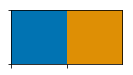

In [22]:
sample_description = pd.read_csv(SAMPLE_DESCRIPTION_FILE, dtype = 'str')

if not set(['warehouse_folder_string', 'fastq_file_string', 'sample', 'read_type']) <= set(sample_description.columns):
    msg = (f'The sample discription file should at least have the following columns:\n'
           f'"warehouse_folder_string": unique string in the name of the data warehouse folder '
           f'containing the fastq files.\n'
           f'"fastq_file_string": string in the fastq files for mapping fastq files to samples.\n'
           f'"sample": user defined sample name.'
           f'"read_type": either "single" or "paired"'
          )
    print(msg)
    
# Remove potential whitespace 
sample_description.apply(lambda x: x.str.strip(), axis=1)
sample_description.genome_browser_track_color = sample_description.genome_browser_track_color.astype(int)
sample_description = sample_description.set_index('sample')

print("\nSample description:")
display(sample_description)    

print('The following colors will be used for UCSC genome browser tracks:')
if 'genome_browser_track_color' in sample_description.columns:
    color_max = sample_description.genome_browser_track_color.max(axis=0)
else:
    color_max = sample_description.shape[0]
    
sns.palplot(sns.color_palette("colorblind", color_max))

## Find, download, merge, and rename fastq files
First, use the *warehouse_folder_string* to search the data warehouse for folders that may contain the data file. Then copy/download fastq files matching *fastq_file_string* in those folders.

Fastq files with the same *file_string will* be merged and renamed using the corresponding *sample* name defined in SAMPLE_DESCRIPTION_FILE.

In [13]:
for folder_string in sample_description.warehouse_folder_string.unique():
    rawfastq_subdir = rawfastq_dir/folder_string
    df = sample_description[sample_description.warehouse_folder_string == folder_string]
    
    if DATA_SOURCE == 'internal_warehouse':
        # Find folder in the warehouse that may contain the fastq files
        cmd = f'ssh {WAREHOUSE_USER}@{WAREHOUSE_SERVER} find ../database4 -type d -name *{folder_string}*'
        print(f'\nSearching folders with {folder_string} in their names on the server {WAREHOUSE_SERVER}')
        print(f'\nUsing command "{cmd}"')
        fastq_folders = check_output(cmd, shell=True).decode().split('\n')
        print('\nFastq folders found:')
        print('\n'.join(fastq_folders))

        # Find fastq files in the folders
        for file_string in df.fastq_file_string:
            sample_name = df[df.fastq_file_string == file_string]['sample'].values[0]
            # Some of the folders may not contain fastq data
            for fastq_folder in fastq_folders:
                cmd = f'ssh {WAREHOUSE_USER}@{WAREHOUSE_SERVER} find {fastq_folder} -type f -name "*{file_string}*R1*"'
                fastq_files = check_output(cmd, shell=True).decode().replace('\n', " ")
                # Escape special characters
                fastq_files = fastq_files.replace("&", "\&").replace(":", "\:")
                # Skip the current fastq_folder if fastq_files have already been found
                if not fastq_files == '': 
                    break
            # Download fastq files from internal server
            print('\nDownloading fastq files ....')
            rawfastq_subdir.mkdir(parents=True, exist_ok=True)
            cmd = f'scp -r {WAREHOUSE_USER}@{WAREHOUSE_SERVER}:"{fastq_files}" {rawfastq_subdir}'
            os.system(cmd)
            # Find fastq file names begining with file_string
            R1_fastq_gz_with_file_string = [str(filename) for filename in Path(fastq_folder).iterdir() 
                                            if re.search(file_string + '.*R1.+fastq.gz$', str(filename))]
            R1_fastq_with_file_string = [str(filename) for filename in Path(fastq_folder).iterdir() 
                                         if re.search(file_string + '.*R1.+fastq$', str(filename))]
            merge_and_rename(R1_fastq_gz_with_file_string, f'{sample_name}.fastq', rawfastq_dir)
            merge_and_rename(R1_fastq_with_file_string, f'{sample_name}.fastq', rawfastq_dir)
        
    elif DATA_SOURCE == 'local':
        cmd = f'find {LOCAL_DATA_SOURCE} -type d -name "*{folder_string}*"'
        # On the local computer, there is usually just one folder for each data set.
        fastq_folder = check_output(cmd, shell=True).decode().strip() 
        print('\nLocal fastq folders found:', fastq_folder)
        rawfastq_subdir.mkdir(parents=True, exist_ok=True)

        # Find fastq files in the folders
        for file_string in df.fastq_file_string:
            sample_name = df[df.fastq_file_string == file_string]['sample'].values[0]
            # Find fastq file names begining with file_string
            R1_fastq_gz_with_file_string = [str(filename) for filename in Path(fastq_folder).iterdir() 
                                            if re.search(file_string + '.*R1.+fastq.gz$', str(filename))]
            R1_fastq_with_file_string = [str(filename) for filename in Path(fastq_folder).iterdir() 
                                         if re.search(file_string + '.*R1.+fastq$', str(filename))]
            merge_and_rename(R1_fastq_gz_with_file_string, f'{sample_name}.fastq', rawfastq_dir)
            merge_and_rename(R1_fastq_with_file_string, f'{sample_name}.fastq', rawfastq_dir)
    
    elif DATA_SOURCE == 'basespace':
        # TODO
        pass
    
    print('\nDone!')


Searching folders with 160411 in their names on the server intron.njms.rutgers.edu

Using command "ssh zhengdh@intron.njms.rutgers.edu find ../database4 -type d -name *160411*"

Fastq folders found:
../database4/Data01/NextSeq/160411_NB500952_0051_AHYFCNBGXX
../database4/Data01/FASTQ/160411_NB500952_0051_AHYFCNBGXX


Serching files using the command ssh zhengdh@intron.njms.rutgers.edu find ../database4/Data01/NextSeq/160411_NB500952_0051_AHYFCNBGXX -type f -name "*ACTGAT*"

Fastq files found:
 


Serching files using the command ssh zhengdh@intron.njms.rutgers.edu find ../database4/Data01/FASTQ/160411_NB500952_0051_AHYFCNBGXX -type f -name "*ACTGAT*"

Fastq files found:
../database4/Data01/FASTQ/160411_NB500952_0051_AHYFCNBGXX/C2C12_diff_4sU/25/ACTGAT_S21_L002_R1_001.fastq.gz ../database4/Data01/FASTQ/160411_NB500952_0051_AHYFCNBGXX/C2C12_diff_4sU/25/ACTGAT_S21_L001_R1_001.fastq.gz ../database4/Data01/FASTQ/160411_NB500952_0051_AHYFCNBGXX/C2C12_diff_4sU/25/ACTGAT_S21_L003_R1_001.fastq

In [14]:
fastq_files = sorted([str(filename.absolute()) for filename in rawfastq_dir.glob('*.fastq')])

if len(fastq_files) == 0:
    print(f"\nPleae put fastq files in the {str(rawfastq_dir)} folder first.")    
    
WORKERS = min(MAX_WORKERS, len(fastq_files))

print(f'\n{WORKERS} workers will be used for all parallel computing.')    


4 workers will be used for all parallel computing.


Count raw fastq records in each fastq file:

In [45]:
# Count raw reads   
with mp.Pool(processes=WORKERS) as pool:
    raw_fastq_counts = pool.map(count_fastq, fastq_files)
    
raw_fastq_counts = pd.DataFrame(raw_fastq_counts, columns = ["File_Name", "Raw"])
raw_fastq_counts["File_Name"] = raw_fastq_counts["File_Name"].str.replace('.fastq', '') 
raw_fastq_counts = raw_fastq_counts.set_index("File_Name")

print('\nRaw fastq counts in each file:')
raw_fastq_counts 


Raw fastq counts in each file:


,Raw
File_Name,
C2C12D_1,12901771
C2C12D_2,16763626
C2C12P_1,11280672
C2C12P_2,16568113


## FASTQ QC and Calculate length of random nucleotides in 3' ligation adapter
Plots sequencing quality. Parallel computing was used for speed. 

For libraries prepared using different versions of 3' adapters (usually in different batches), the numbers of random nucleotides could be different. This code will also figure out the number of random nucleotides (*random_NT_lens*) in the 3' adapter (5' end of the reads when the libraries are sequenced in reverse direction). The *random_NT_lens* will be used for identifying PASS reads and unique PASS reads later. 

In [17]:
result_dir_str = str(result_dir.absolute()) # For R input


Number of random nucleotides in 5' end of the fastq reads (due to 3' ligation adapter):

C2C12D_1 C2C12D_2 C2C12P_1 C2C12P_2 
       3        3        3        3 



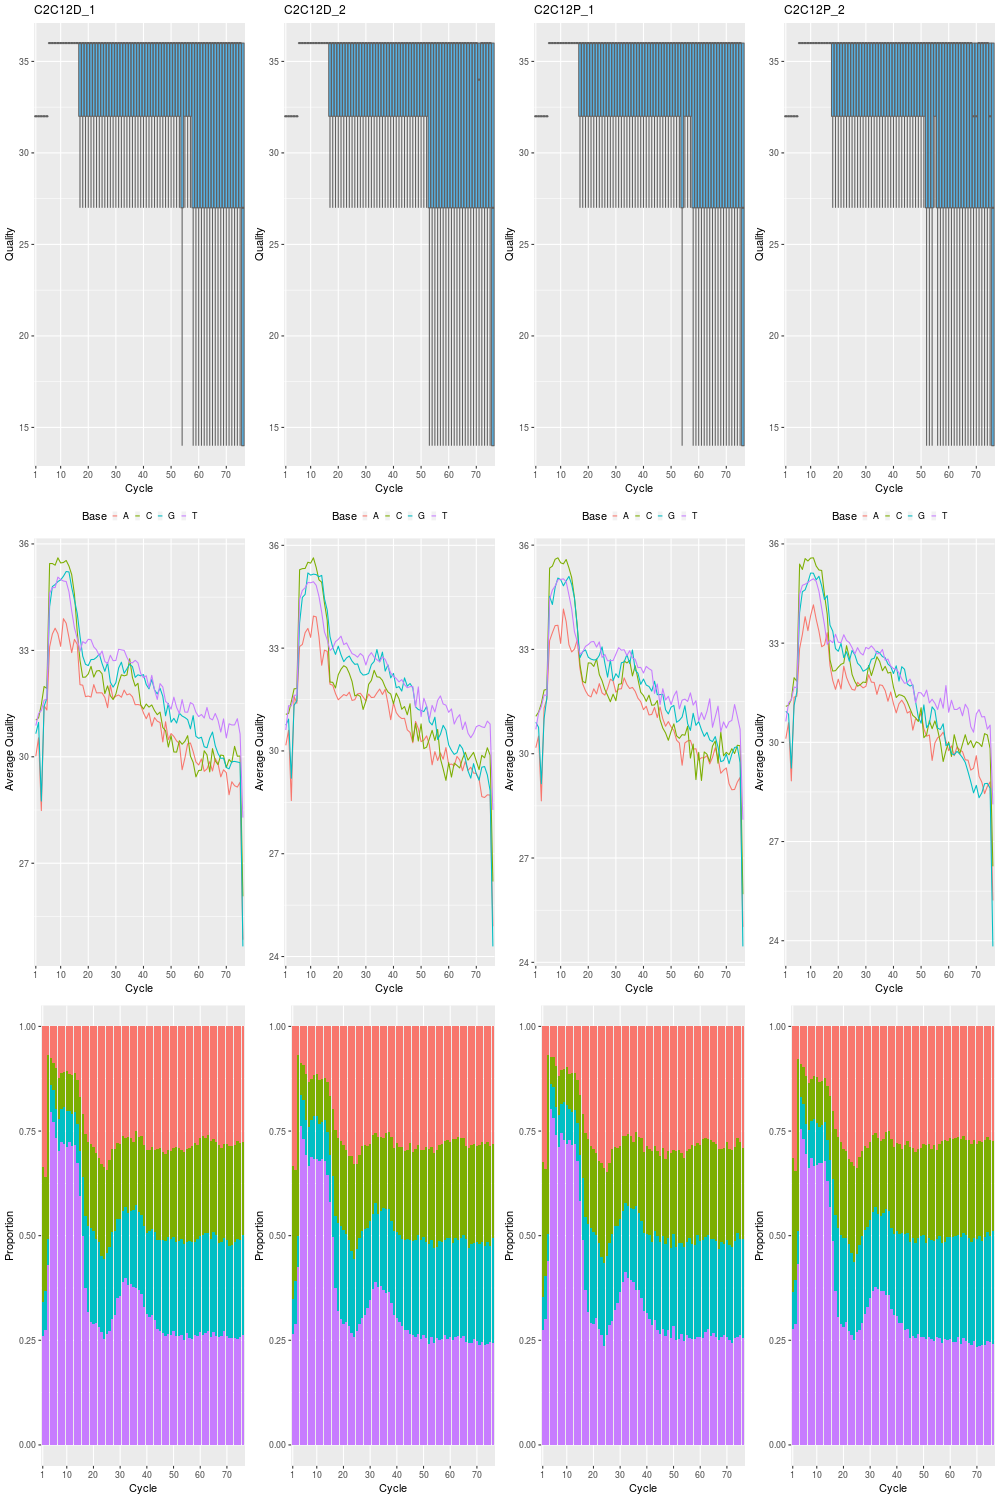

In [19]:
%%R -i fastq_files,FASTQ_QC_PLOT_NUM_COLUMNS,result_dir_str,WORKERS -w 1000 -h 1500 -o random_NT_lens

## Load helper functions
source("/home/dinghai/dev/3-prime-READS-plus/modules/FastqQC.R")
library(foreach)
library(doParallel)

## Step 1: Creat list of plots using parellel computing             
registerDoParallel(WORKERS)   
fqlist = foreach(f = 1:length(fastq_files), 
                 .packages = c("ShortRead", "Biostrings")) %dopar% {
    seeFastq(fastq = fastq_files[[f]])
    }
names(fqlist) = sapply(fastq_files, function(x) sub(".+\\/(.+).fastq", "\\1", x))                     

## Step 2: Output pdf and browser image              
mycol = seq(along = fqlist)     
myrow = c(1, 3, 2)
n = min(FASTQ_QC_PLOT_NUM_COLUMNS, length(fastq_files))                                                
if(length(mycol) %% n){
  groups = 0:floor(length(mycol)/n)
}else{
  groups = 0:(length(mycol)/n - 1)
}  
                       
# Make pdf plots                        
pdf(file.path(result_dir_str, "fastqReport.pdf"), height=20, width=4*n)                         
for(group in groups){
  if(group < max(groups)){
    subcol = mycol[n*group + 1:n]
  }else{
    subcol = mycol[(n*group + 1):length(mycol)]
  }
  seeFastqPlot(fqlist[subcol], arrange = myrow, n = n)
}
dev.off()  
                       
# Print to screen
for(group in groups){
  if(group < max(groups)){
    subcol = mycol[n*group + 1:n]
  }else{
    subcol = mycol[(n*group + 1):length(mycol)]
  }
  seeFastqPlot(fqlist[subcol], arrange = myrow, n = n)
}       
                
# Automatically figure out the number of random nucleotides in the 3' adapter (5' end of the reads 
                       # when the libraries are sequenced in reverse direction) 
cycle_with_max_T_frequency = function(fq){
    base_frequency = fq$bstats
    T_frequency = subset(base_frequency, Base == "T")
    # The number of random nucleotides in the 3'adapter is also where the frequency of T increased most 
    which.max(diff(T_frequency$Frequency))
}
                       
random_NT_lens = sapply(fqlist, cycle_with_max_T_frequency)
names(random_NT_lens) = names(fqlist)

cat("\nNumber of random nucleotides in 5' end of the fastq reads (due to 3' ligation adapter):\n\n")
print(random_NT_lens)
cat("\n")                       

## Clip adapters 
Remove the read's 3' end adapter (originated from 5' RNA ligation adapter) from the reads using cutadapt. Parallel computing was used for speed. 

In [38]:
cmds = [] 
for sample_name in sample_description.index:
    fastq_file = str(rawfastq_dir/f'{sample_name}.fastq')
    read_type = sample_description.loc[sample_name, 'read_type']
    if read_type == 'single':
        cmd = (f'cutadapt -a NNNNTGGAATTCTCGGGTGCCAAGG -n 1 -O 10 -m {CUTADAPT_MINLEN} -f fastq -q 10 {fastq_file} '
               f'-o {fastq_file.replace(".fastq", ".cut.fastq").replace("rawfastq", "fastq")} '
               f'&& rm {fastq_file}')
    elif read_type == 'paired':
        cmd = (f'cutadapt -u -75 -a NNNNTGGAATTCTCGGGTGCCAAGG -n 1 -O 10 -m {CUTADAPT_MINLEN} -f fastq '
               f'-q 10 {fastq_file} -o {fastq_file.replace(".fastq", ".cut.fastq").replace("rawfastq", "fastq")} '
               f'&& rm {fastq_file}')
    cmds.append(cmd)

In [47]:
print("\nRemoving ligation adapters from fastq reads in the following files:\n") 
print('\n'.join([fastq_file.split('/')[-1] for fastq_file in fastq_files]))

with mp.Pool(processes = WORKERS) as pool: 
    pool.map(os.system, cmds)
    
print('\nDone!')


Removing ligation adapters from fastq reads in the following files:

C2C12D_1.fastq
C2C12D_2.fastq
C2C12P_1.fastq
C2C12P_2.fastq

Done!


## Trim 5' Ts 

In [67]:
cutadapt_outputs = sorted([str(filename.absolute()) for filename in fastq_dir.glob('*cut.fastq')])

print("\nTrimming 5' T-stretches from fastq reads in the following files:\n") 
print('\n'.join([fastq_file.split('/')[-1] for fastq_file in cutadapt_outputs]))

with mp.Pool(processes = WORKERS) as pool:
    trimmed_fastq_counts = pool.starmap(trim_write_count_fastq, 
                            list(zip(cutadapt_outputs, list(random_NT_lens), [4]*len(random_NT_lens))))
    
if SAVE_SPACE:
    cmd = 'rm ' + ' '.join(cutadapt_outputs)
    os.system(cmd)    

print('\nDone!')

trimmed_fastq_counts = pd.DataFrame(trimmed_fastq_counts, columns = ["File_Name", "Cut", "Trimmed"])
trimmed_fastq_counts["File_Name"] = trimmed_fastq_counts["File_Name"].str.replace('.cut.fastq', '')  
trimmed_fastq_counts = trimmed_fastq_counts.set_index("File_Name")
fastq_counts = pd.concat([raw_fastq_counts, trimmed_fastq_counts], axis = 1)

print('\nFastq counts in each file:')
fastq_counts


Trimming 5' T-stretches from fastq reads in the following files:

C2C12D_1.cut.fastq
C2C12D_2.cut.fastq
C2C12P_1.cut.fastq
C2C12P_2.cut.fastq

Done!

Fastq counts in each file:


,Raw,Cut,Trimmed
C2C12D_1,12901771,12397026,9739930
C2C12D_2,16763626,15978740,11795122
C2C12P_1,11280672,10775762,8563380
C2C12P_2,16568113,15742372,11733243


## Map the reads to the genome using STAR 

AlignEndsType is set to EndToEnd.
According to the STAR manual, add the following lines to /etc/sysctl.conf:
1. kernel.shmmax = 31000000000 
2. kernel.shmall = 7568360

Then run 'sudo /sbin/sysctl -p' to allow large shared memory blocks.

In [68]:
trimmed_fastq_files = sorted([str(filename.absolute()) for filename in fastq_dir.glob('*trimmed.fastq')])
# Commands for mapping reads
cmds = [(f'STAR --runThreadN {WORKERS} --genomeDir {genome_index} --genomeLoad LoadAndKeep '
         f'--readFilesIn {fastq_file} --alignEndsType EndToEnd --outFilterType BySJout '
         f'--outFilterMultimapNmax 10 --alignSJoverhangMin 8 --alignSJDBoverhangMin 1 '
         f'--alignIntronMin 20 --alignIntronMax 1000000 --outFileNamePrefix '
         f'{fastq_file.replace("/fastq/", "/sam/").replace("cut.trimmed.fastq", "")}') 
         for fastq_file in trimmed_fastq_files]

# Commands for removing fastq files
cmds_rm = ['rm ' + fastq_file for fastq_file in trimmed_fastq_files]  

In [69]:
print(f'\nMapping reads from the following files to {GENOME}:\n') 
print('\n'.join([fastq_file.split('/')[-1] for fastq_file in trimmed_fastq_files]))

# Map reads and then delete fastq files immediately
for i in range(len(cmds)):
    os.system(cmds[i])    
    if SAVE_SPACE:
        os.system(cmds_rm[i])
    
# Remove genome from memory. Note "--genomeDir" is still needed!
cmd = f'STAR --genomeDir {genome_index} --genomeLoad Remove'
os.system(cmd)

print('\nDone!')


Mapping reads from the following files to mm9:

C2C12D_1.cut.trimmed.fastq
C2C12D_2.cut.trimmed.fastq
C2C12P_1.cut.trimmed.fastq
C2C12P_2.cut.trimmed.fastq

Done!


## Identfy PASS reads

1. Unlike pool.map(), pool.starmap() allows passing multiple arguments to functions.
2. If I pass genome to each process, I will get an error.
3. If the pick_PASS is not defined in the notebook but loaded from PASS.py, genome will not be available for all processes.

In [70]:
def split_sam(sam_file, min_mapq = 10, direction = 'reverse', spike_in = None):
    '''Split a sam_file into PASS, nonpass, and spike-in sam files.

    Loop through records in the sam file, if the record is PASS, write to
    pass_file. Mapped non-PASS reads are saved in nonpass_file. Reads mapped to 
    rRNA genes are skipped. Sequencing direction can only be reverse or forward. 

    Attach matched tail length (ML), unmatched tail length (UL), and last mapped
    position (LM) to the end of readname. The head (such as 'TS11AAC') and the 
    tail (such as 'ML:i:4\tUL:i:9\tLM:i:1234') of the read name is the unique 
    identifier of the read.
    
    Arguments:
    sam_file: string. Name of input sam file.
    min_mapq: int. Minimum MAPQ score
    direction: string. Either 'reverse' (default) or 'forward'
    spike_in: a 4-charactor string for identifying spike-in RNA. For example,
    spike_in = 'ychr' for spike-in yeast RNA if yeast chromosomes are named as 'ychr1', 
    'ychrM', etc. 
    
    Outputs:
    Separate sam files containing either PASS reads, nonPASS reads, or spike-ins.
    '''
    pass_file = open(sam_file.replace('.sam', '.pass'), 'w')
    nonpass_file = open(sam_file.replace('.sam', '.nonpass'), 'w')
    if spike_in: spike_in_file = open(sam_file.replace('.sam', '.spike_in'), 'w')
    
    lap = 0

    with open(sam_file, 'r') as fin:
        for line in fin:
            # Skip header
            if line[0] == '@':
                pass_file.write(line)
                nonpass_file.write(line)
                if spike_in: spike_in_file.write(line)
                continue
            # Process each line
            (readname, flag, chromosome, position, mapq, cigar) = line.split()[:6]
            position = int(position)
            mapq = int(mapq)

            # Discard reads with low mapping scores
            if mapq < min_mapq:
                continue
            # Record reads mapped to spiked-in yeast genome 
            if spike_in and chromosome[:4] == spike_in:  
                spike_in_file.write(line)
                continue
            # Ignore reads mapped to other chromosomes, such as 'BK000964'
            if not chromosome[:3] == 'chr':
                continue

            # Extract the T-stretch length encoded in the readname
            match = re.match('TS(\d+)', line)
            t_stretch_len = int(match.groups()[0])

            # Get genomic sequence downstream of the LAP (last mapped position).
            # (The length of returned sequence is t_stretch_len.)
            if (direction.lower() == 'reverse' and flag == '16') or \
                    (direction.lower() == 'forward' and flag == '0'):
                strand = '+'
                # Process cigar to determine the LAP.
                # Insertion (I) will not affect the covered distance.
                nums = re.split('[MDN]', re.sub('\d+I', '', cigar))[:-1]
                covered = sum(int(x) for x in nums)
                # get_seq() returns reverse complemented sequence if strand == '-'
                downstream_seq = get_seq(chromosome, strand,
                                         start = position + covered,
                                         end = position + covered + t_stretch_len - 1,
                                         genome = genome)
                lap = position + covered - 1
            elif (direction.lower() == 'reverse' and flag == '0') or \
                    (direction.lower() == 'forward' and flag == '16'):
                strand = '-'
                downstream_seq = get_seq(chromosome, strand,
                                         start = position - t_stretch_len, 
                                         end = position - 1,
                                         genome = genome)
                lap = position
            else:
                continue

            # If the 5' T-stretch was trimmed twice (like 'TTTTTTTGTTTT')
            # and if GTTTT (reverse-compliment: AAAAC) comes from the genome,
            # update the downstream_seq, lap, and t_stretch_len
            elements = readname.split('::')
            if len(elements) == 2:
                elements[1] = elements[1].split(':')[0]   
                match = re.match(reverse_complement(elements[1]), downstream_seq)
                if match:
                    downstream_seq = downstream_seq[len(elements[1]):]
                    t_stretch_len -= len(elements[1])
                    if strand == '+':
                        lap += len(elements[1])
                    if strand == '-':
                        lap -= len(elements[1])
            
            # If the t_stretch_len is reduced enough, no need to analyze downstream sequence
            #assert t_stretch_len >= 0
            
            if t_stretch_len == 0:
                nonpass_file.write(line.strip() + '\tML:i:%d\tUL:i:%d\tLM:i:%d\n'
                                      % (0, 0, lap))
                continue

            # Check if downstream sequence matches trimmed T-stretches 
            if not downstream_seq[:-1] == 'A' * (t_stretch_len - 1):
                match = re.match('A+', downstream_seq)
                matched_len = len(match.group()) if match else 0
                # ML: Matched Length 
                # UL: Unmatched Length
                # LM: Last Mapped position(UL) 
                pass_file.write(line.strip() + '\tML:i:%d\tUL:i:%d\tLM:i:%d\n'
                                    % (matched_len, t_stretch_len - matched_len, lap))
            # If t_stretch_len == 1, the following block will also run.
            else:
                match = re.match('A*', downstream_seq)
                matched_len = len(match.group())  
                nonpass_file.write(line.strip() + '\tML:i:%d\tUL:i:%d\tLM:i:%d\n'
                                      % (matched_len, t_stretch_len - matched_len, lap))
    pass_file.close()
    nonpass_file.close()
    if spike_in: spike_in_file.close()
    
    os.system('rm ' + sam_file)

In [71]:
# List of sam files as input
sam_files = sorted(str(sam_file) for sam_file in sam_dir.glob('*Aligned.out.sam'))
l = len(sam_files)

print('\nPicking PASS reads from the following files:\n') 
print('\n'.join([sam_file.split('/')[-1] for sam_file in sam_files]))

# Genome loaded into memory is available for all processes
genome = load_fasta_genome(genome_dir)

# Try parallel computing, which requires more disk space
try:
    with mp.Pool(processes = WORKERS) as pool:
        pool.starmap(split_sam, zip(sam_files, [MIN_MAPQ]*l, [SEQ_DIRECTION]*l, [SPIKE_IN]*l))
except OSError:
    os.system(f'rm {str(sam_dir)}/*pass')
    if SPIKE_IN: os.system(f'rm {str(sam_dir)}/*.spike_in')
    print("\nNo space left on device. Trying again with parallel computing turned off.")
    for sam_file in sam_files:
        print("Processing ", sam_file)
        split_sam(sam_file = sam_file)

# Release memory    
del genome  

print('\nDone!') 


Picking PASS reads from the following files:

C2C12D_1.Aligned.out.sam
C2C12D_2.Aligned.out.sam
C2C12P_1.Aligned.out.sam
C2C12P_2.Aligned.out.sam

Done!


## Pick unique PASS reads

In [72]:
pass_files = sorted(str(pass_file) for pass_file in sam_dir.glob('*Aligned.out.pass'))
print('\nPicking unique PASS reads from the following files:\n') 
print('\n'.join([pass_file.split('/')[-1] for pass_file in pass_files]))

with mp.Pool(processes = WORKERS) as pool:
    pool.starmap(pick_unique_pass, list(zip(pass_files, list(random_NT_lens))))
    
print('\nDone!')     


Picking unique PASS reads from the following files:

C2C12D_1.Aligned.out.pass
C2C12D_2.Aligned.out.pass
C2C12P_1.Aligned.out.pass
C2C12P_2.Aligned.out.pass

Done!


## Cluster all PASS or unique PASS reads

In [73]:
# Cluster all PASS reads
pass_files = sorted(str(pass_file) for pass_file in sam_dir.glob('*Aligned.out.pass'))
pass_reads_output = result_dir/'clusters.using.all.reads.csv'

cluster_pass_reads(pass_files, output = pass_reads_output,
                   direction = SEQ_DIRECTION, max_distance = MAX_DISTANCE)

Reading sam files containing PASS reads ...
Clustering reads ...
Writing to output file ...
Done!


In [74]:
# Cluster unique PASS reads
upass_files = sorted(str(pass_file) for pass_file in sam_dir.glob('*Aligned.out.unique.pass'))
upass_reads_output = result_dir/'clusters.using.unique.reads.csv'

cluster_pass_reads(upass_files, output = upass_reads_output,
                   direction = SEQ_DIRECTION, max_distance = MAX_DISTANCE)


Reading sam files containing PASS reads ...
Clustering reads ...
Writing to output file ...
Done!


## Read number statistics

In [106]:
with mp.Pool(processes = WORKERS) as pool: 
    pass_counts = pool.map(count_sam, pass_files)
    
pass_counts = pd.DataFrame(pass_counts, columns = ['Sample', 'PASS'])
pass_counts.iloc[:,0] = pass_counts.iloc[:,0].str.replace('.Aligned.out.pass', '')
pass_counts = pass_counts.set_index('Sample')   



nonpass_files = sorted(str(nonpass_file) for nonpass_file in sam_dir.glob('*Aligned.out.nonpass'))
with mp.Pool(processes = WORKERS) as pool: 
    nonpass_counts = pool.map(count_sam, nonpass_files)
    
nonpass_counts = pd.DataFrame(nonpass_counts, columns = ['Sample', 'nonPASS'])
nonpass_counts.iloc[:,0] = nonpass_counts.iloc[:,0].str.replace('.Aligned.out.nonpass', '')
nonpass_counts = nonpass_counts.set_index('Sample')  


    
with mp.Pool(processes = WORKERS) as pool: 
    upass_counts = pool.map(count_sam, upass_files)
    
upass_counts = pd.DataFrame(upass_counts, columns = ['Sample', 'uPASS'])
upass_counts.iloc[:,0] = upass_counts.iloc[:,0].str.replace('.Aligned.out.unique.pass', '')
upass_counts = upass_counts.set_index('Sample')    



if SPIKE_IN: 
    spike_in_files = sorted(str(nonpass_file) for nonpass_file in sam_dir.glob('*Aligned.out.spike_in'))
    with mp.Pool(processes = WORKERS) as pool: 
        spike_in_counts = pool.map(count_sam, spike_in_files)
    spike_in_counts = pd.DataFrame(spike_in_counts, columns = ['Sample', 'Spike-in'])
    spike_in_counts.iloc[:,0] = spike_in_counts.iloc[:,0].str.replace('.Aligned.out.Spike-in', '')
    spike_in_counts = spike_in_counts.set_index('Sample') 
    


In [140]:
mapped_counts = pd.DataFrame(pd.concat([pass_counts, nonpass_counts], 
                                       axis=1).sum(axis=1), columns = ['Mapped'])

if SPIKE_IN: 
    count_stats = pd.concat([fastq_counts, mapped_counts, pass_counts, 
                             nonpass_counts, upass_counts, spike_in_counts], axis=1)
else:
    count_stats = pd.concat([fastq_counts, mapped_counts, pass_counts, 
                             nonpass_counts, upass_counts], axis=1)

count_stats['Cut%'] = round(count_stats.Cut/count_stats.Raw * 100, 1)
count_stats['Trimmed%'] = round(count_stats.Trimmed/count_stats.Cut * 100, 1)
count_stats['MAP%'] = round(count_stats.Mapped/count_stats.Cut * 100, 1)
count_stats['PASS%'] = round(count_stats.PASS/count_stats.Mapped * 100, 1)
count_stats['uPASS%'] = round(count_stats.uPASS/count_stats.PASS * 100, 1)

count_stats.to_csv(result_dir/'ReadStats.csv')

display(count_stats)

,Raw,Cut,Trimmed,Mapped,PASS,nonPASS,uPASS,Cut%,Trimmed%,MAP%,PASS%,uPASS%
Sample,,,,,,,,,,,,
C2C12D_1,12901771,12397026,9739930,8537730,4489793,4047937,1832400,96.1,78.6,68.9,52.6,40.8
C2C12D_2,16763626,15978740,11795122,10972179,5169233,5802946,2073143,95.3,73.8,68.7,47.1,40.1
C2C12P_1,11280672,10775762,8563380,7143739,3836394,3307345,1628222,95.5,79.5,66.3,53.7,42.4
C2C12P_2,16568113,15742372,11733243,10406929,4826574,5580355,2031736,95.0,74.5,66.1,46.4,42.1


## T-stretch statistics

In [141]:
pass_files = sorted([str(sam_file) for sam_file in sam_dir.glob('*.Aligned.out.pass')])
nonpass_files = sorted([str(sam_file) for sam_file in sam_dir.glob('*.Aligned.out.nonpass')])

pass_TS = summarize_5T_stretch(sam_files = pass_files, processes = WORKERS, max_TS = 25)
nonpass_TS = summarize_5T_stretch(sam_files = nonpass_files, processes = WORKERS, max_TS = 25)

pass_TS.columns = pass_TS.columns + '.PASS'
nonpass_TS.columns = nonpass_TS.columns + '.nonPASS'

TS = pd.concat([pass_TS, nonpass_TS], axis = 1)

In [142]:
display(TS)

,C2C12D_1.PASS,C2C12D_2.PASS,C2C12P_1.PASS,C2C12P_2.PASS,C2C12D_1.nonPASS,C2C12D_2.nonPASS,C2C12P_1.nonPASS,C2C12P_2.nonPASS
T_Stretch_Length,,,,,,,,
0,0,0,0,0,2000224,3126792,1634765,2960093
1,0,0,0,0,1065704,1421741,845853,1360394
2,26951,33287,23126,34187,505352,657286,408240,651404
3,12848,16625,11027,17603,143384,191543,123008,199540
4,12911,16502,12140,19292,40562,54154,34155,56241
5,22911,27231,21657,31764,15036,18499,13253,20968
6,43355,50925,42752,60634,14067,16180,13092,18802
7,88473,102926,87717,116531,29153,36545,25915,36937
8,167443,196638,163820,200532,30080,37007,29116,40104


png 
  2 


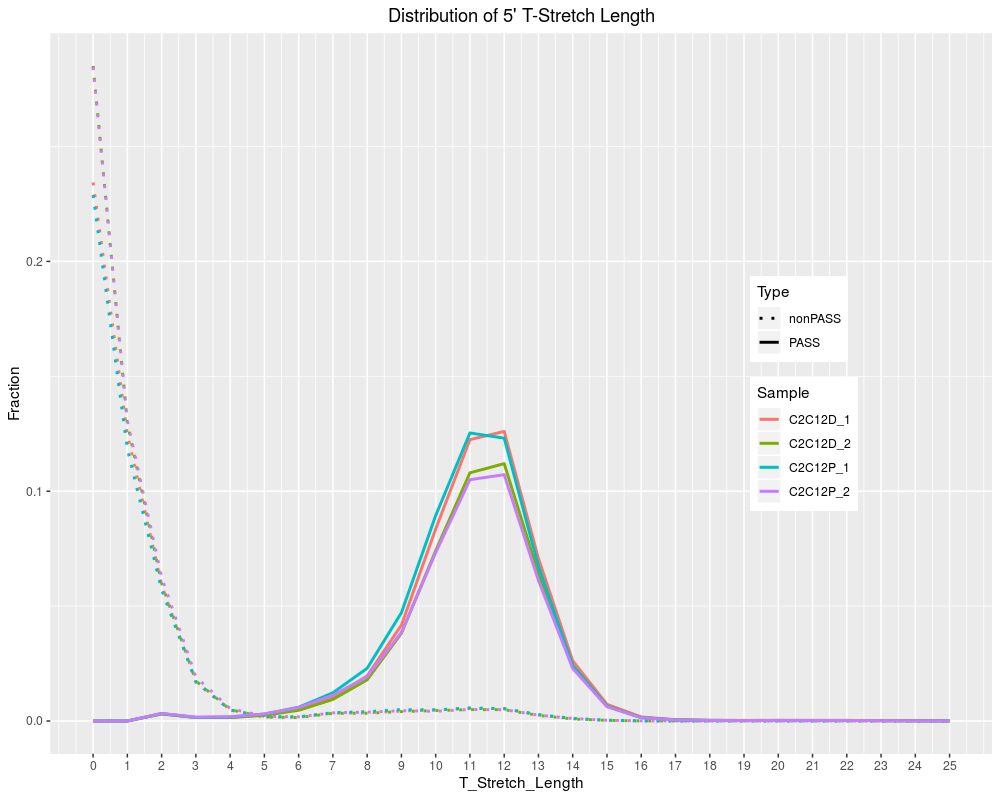

In [143]:
%%R -i result_dir_str,TS -w 1000 -h 800 -r 100

require(dplyr)
require(tidyr)
require(ggplot2)

# Calculation using dplyr and tidyr
TS = mutate(TS, T_Stretch_Length = as.numeric(rownames(TS))) %>% 
     gather(sample_name, Count, -T_Stretch_Length) %>%
     mutate(Type = sub("^.+\\.(.+)$", "\\1", sample_name)) %>%
     mutate(Sample = sub("(^.+)\\..+$", "\\1", sample_name)) %>%
     group_by(Sample) %>% 
     mutate(Fraction = Count/sum(Count))  

# Create plot 
p = ggplot(TS, aes(x = T_Stretch_Length, y = Fraction, color = Sample)) + 
    geom_line(aes(linetype = Type), size = 1) + 
    scale_linetype_manual(values = c(3,1)) +
    scale_x_continuous(breaks = 0:25) +
    theme(legend.position=c(0.8, 0.5))  + 
    ggtitle("Distribution of 5' T-Stretch Length") +
    theme(plot.title = element_text(hjust = 0.5))

# Display in notebook
print(p)

# Save to pdf
pdf(file.path(result_dir_str, 'T_stretch_len_all.pdf'), 8, 6)
print(p)
dev.off()

## Create UCSC genome browser tracks 

In [40]:
pass_files = sorted([str(sam_file) for sam_file in sam_dir.glob('*.Aligned.out.pass')])
nonpass_files = sorted([str(sam_file) for sam_file in sam_dir.glob('*.Aligned.out.nonpass')])

In [15]:
# Make UCSC genome browser tracks for PASS reads
make_url(project = PROJECT, experiment = EXPERIMENT, sam_dir= sam_dir, sam_files = pass_files, 
         genome_size = genome_size, sample_description = sample_description, processes = WORKERS, 
         keep_bam = False, bigDataUrl = f'http://{HTTP_SERVER}/{HTTP_USER}/bigwig/')

# Prepare for uploading files
pass_bw_dir = sam_dir/PROJECT/EXPERIMENT/'PASS'
pass_bw_dir.mkdir(parents=True, exist_ok=True)

os.system(f'mv {str(sam_dir)}/*.bw {str(pass_bw_dir)}')
os.system(f'mv {str(sam_dir)}/bigwigCaller.txt {str(pass_bw_dir)}')

In [17]:
# Make UCSC genome browser tracks for nonPASS reads
make_url(project = PROJECT, experiment = EXPERIMENT, sam_dir= sam_dir, sam_files = nonpass_files, 
         genome_size = genome_size, sample_description = sample_description, processes = WORKERS,
         keep_bam = False, bigDataUrl = f'http://{HTTP_SERVER}/{HTTP_USER}/bigwig/')

# Prepare for uploading files
nonpass_bw_dir = sam_dir/PROJECT/EXPERIMENT/'nonPASS'
nonpass_bw_dir.mkdir(parents=True, exist_ok=True)

os.system(f'mv {str(sam_dir)}/*.bw {str(nonpass_bw_dir)}')
os.system(f'mv {str(sam_dir)}/bigwigCaller.txt {str(nonpass_bw_dir)}')

In [19]:
# Upload the bigwig and track definition files to the http-enabled server
cmd = f'ssh {HTTP_USER}@{HTTP_SERVER} mkdir ~/../www/{HTTP_USER}/bigwig/{PROJECT}'
os.system(cmd)

cmd = f'scp -r {str(sam_dir/PROJECT/EXPERIMENT)} {HTTP_USER}@{HTTP_SERVER}:~/../www/{HTTP_USER}/bigwig/{PROJECT}'
if not os.system(cmd):
    print('bigWig files have been uploaded to http server.')
    os.system(f'rm -r {str(sam_dir/PROJECT)}')
    if SAVE_SPACE: os.system(f'rm -r {str(sam_dir)}')
    
    pass_url = (f'https://genome.ucsc.edu/cgi-bin/hgTracks?db={GENOME}'
                f'&position=chr17%3A35092728-35095537&hgct_customText='
                f'http://{HTTP_SERVER}/{HTTP_USER}/bigwig/{PROJECT}/'
                f'{EXPERIMENT}/PASS/bigwigCaller.txt'
                )    

    print('The following URL for PASS reads will be opened in a new tab automatically:')
    print(pass_url, '\n')
    sleep(5)
    import webbrowser
    _ = webbrowser.open(pass_url)

    nonpass_url = (f'https://genome.ucsc.edu/cgi-bin/hgTracks?db={GENOME}'
                   f'&position=chr17%3A35092728-35095537&hgct_customText='
                   f'http://{HTTP_SERVER}/{HTTP_USER}/bigwig/{PROJECT}/'
                   f'{EXPERIMENT}/nonPASS/bigwigCaller.txt'
                   ) 

    print('The following URL for both PASS and nonPASS reads will be opened in a new tab automatically:')
    print(nonpass_url)
    sleep(15)
    _ = webbrowser.open(nonpass_url)

else:
    print('Cannot upload bigWig files to http server. Please make sure the server is available.')

bigWig files have been uploaded to http server.
The following URL for PASS reads will be opened in a new tab automatically:
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&position=chr17%3A35092728-35095537&hgct_customText=http://intron.njms.rutgers.edu/zhengdh/bigwig/ER/160411_C2C12_Dif/PASS/bigwigCaller.txt 

The following URL for nonPASS reads will be opened in a new tab automatically:
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&position=chr17%3A35092728-35095537&hgct_customText=http://intron.njms.rutgers.edu/zhengdh/bigwig/ER/160411_C2C12_Dif/nonPASS/bigwigCaller.txt


As an example, we can take a look at the PASS and nonPASS reads mappted to the 3'UTRs of Nmt1 gene APA isoforms.
![Nmt1 3'UTR](images/Nmt1_3UTR.png)
We can see that in the PASS tracks, the reads are concentrated at two peaks, representing two pA sites. On the other hand, the nonPASS tracks have lots of reads mapped to the 3'UTRs, although their are peaks at the two pA sites too, suggesting that the nonPASS reads might be useful for validation of APA.

What are the nonPASS read peaks? Here is one in exon 2 of Nmt1:
![Nmt1 exon 2](images/Nmt1_exon_2.png)
We can see that the sequence surrounding the 3'end of the reads is highly A-rich. Maybe those seqence can be bind by the DNA/LNA oligo and cut by RNaseH, suggesting that increasing the RNaseH reaction temperature or decreasing the amount of DNA/RNA oligo may may help. 

**This is the end for this notebook. The pA cluster files can be used for further analysis.**